# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import scipy.stats

### Load Data

In [3]:
from mls import locate_data

In [4]:
blobs = pd.read_hdf(locate_data('blobs_data.hf5'))

## Statistical Methods

The boundary between probability and statistics is somewhat gray (similar to astronomy and astrophysics).  However, you can roughly think of statistics as the applied cousin of probability theory.

### Expectation

Given a probability density $P(x,y)$, and an arbitrary function $g(x,y)$ of the same random variables, the **expectation value** of $g$ is defined as:
$$
\langle g\rangle \equiv \iint dx dy\, g(x,y) P(x,y) \; .
$$
Note that the result is just a number, and not a function of either $x$ or $y$. Also, $g$ might have dimensions, which do not need to match those of the probability density $P$, so $\langle g\rangle$ generally has dimensions.

Sometimes the assumed PDF is indicated with a subscript, $\langle g\rangle_P$, which is helpful, but more often not shown.

When $g(x,y) = x^n$, the resulting expectation value is called a **moment of x**. (The same definitions apply to $y$, via $g(x,y) = y^n$.) The case $n=0$ is just the normalization integral $\langle \mathbb{1}\rangle = 1$.  Low-order moments have familiar names:
 - $n=1$ yields the **mean of x**, $\overline{x} \equiv \langle x\rangle$.
 - $n=2$ yields the **root-mean square (RMS) of x**, $\langle x^2\rangle$.
 
Another named expectation value is the **variance of x**, which combines the mean and RMS,
$$
\sigma_x^2 \equiv \langle\left( x - \overline{x} \right)^2\rangle \; ,
$$
where $\sigma_x$ is called the **standard deviation of x**.

Finally, the **correlation between x and y** is defined as:
$$
\text{Corr}_{xy} \equiv \langle\left( x - \overline{x}\right) \left( y - \overline{y}\right)\rangle \; .
$$
A useful combination of the correlation and variances is the **correlation coefficient**,
$$
\rho_{xy} \equiv \frac{\text{Corr}_{x,y}}{\sigma_x \sigma_y} \; ,
$$
which, by construction, must be in the range $[-1, +1]$. Larger values of $|\rho_{xy}|$ indicate that $x$ and $y$ are measuring related properties of the outcome so, together, carry less information than when $\rho_{xy} \simeq 0$. In the limit of $|\rho_{xy}| = 1$, $y = y(x)$ is entirely determined by $x$, so carries no new information.

We say that the variance and correlation are both *second-order moments* since they are expectation values of second-degree polynomials.

We call the random variables $x$ and $y$ **uncorrelated** when:
$$
x,y\, \text{uncorrelated}\quad\Rightarrow\quad \text{Corr}_{xy} = \rho_{xy} = 0 \; .
$$

To obtain an **empirical estimate** of the quantities above derived from your data, use the corresponding numpy functions, e.g.

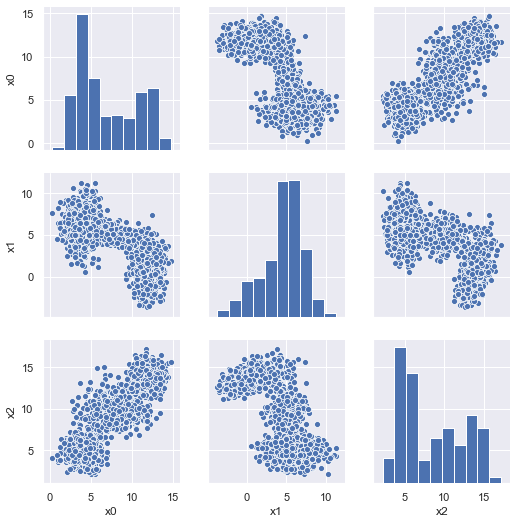

In [14]:
blobs.describe()
sns.pairplot(blobs)

In [6]:
np.mean(blobs, axis=0)

x0    6.920270
x1    4.502004
x2    8.492347
dtype: float64

In [7]:
np.var(blobs, axis=0)

x0    12.684951
x1     6.807913
x2    15.503924
dtype: float64

In [8]:
np.std(blobs, axis=0)

x0    3.561594
x1    2.609198
x2    3.937502
dtype: float64

In [9]:
assert np.allclose(np.std(blobs, axis=0) ** 2, np.var(blobs, axis=0))

In [10]:
assert np.allclose(
    np.mean((blobs - np.mean(blobs, axis=0)) ** 2, axis=0),
    np.var(blobs, axis=0))

The definition $\sigma_x^2 = \langle\left( x - \overline{x} \right)^2\rangle$, suggests that two passes through the data are necessary to calculate variance: one to calculate $\overline{x}$ and another to calculate the residual expectation. Expanding this definition, we obtain a formula
$$
\sigma_x^2 = \langle x^2\rangle - \langle x\rangle^2
$$
that can be evaluated in a single pass by simultaneously accumulating the first and second moments of $x$. However, this approach should generally not be used since it involves a cancellation between relatively large quantities that is subject to large round-off error. More details and recommended one-pass (aka "online") formulas are [here](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance).

### Covariance

It is useful to construct the **covariance matrix** $C$ with elements:
$$
C \equiv \begin{bmatrix}
\sigma_x^2 & \rho_{x,y} \sigma_x \sigma_y \\
\rho_{x,y} \sigma_x \sigma_y & \sigma_y^2 \\
\end{bmatrix}
$$
With more than 2 random variables, $x_0, x_1, \ldots$, this matrix generalizes to:
$$
C_{ij} = \langle \left( x_i - \overline{x}_i\right) \left( x_j - \overline{x}_j\right)\rangle \; .
$$
Comparing with the definitions above, we find variances on the diagonal:
$$
C_{ii} = \sigma_i^2
$$
and symmetric correlations on the off-diagonals:
$$
C_{ij} = C_{ji} = \rho_{ij} \sigma_i \sigma_j \; .
$$
(The covariance is not only symmetric but also [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix)).

The covariance matrix is similar to a pairplot, with each $2\times 2$ submatrix
$$
\begin{bmatrix}
\sigma_i^2 & \rho_{ij} \sigma_i \sigma_j \\
\rho_{ij} \sigma_i \sigma_j & \sigma_j^2 \\
\end{bmatrix}
$$
describing a 2D elllipse in the $(x_i, x_j)$ plane:
![Ellipse Parameters](img/Statistics/Ellipse.png)

Note that you can directly read off the correlation coefficient $\rho_{ij}$ from any of the points where the ellipse touches its bounding box. The ellipse rotation angle $\theta$ is given by:
$$
\tan 2\theta = \frac{2 C_{ij}}{C_{ii} - C_{jj}} = \frac{2\rho_{ij}\sigma_i\sigma_j}{\sigma_i^2 - \sigma_j^2}
$$
and its [principal axes](https://en.wikipedia.org/wiki/Semi-major_and_semi-minor_axes) have lengths:
$$
a_\pm = 2\sqrt{C_{ii} + C_{jj} \pm d} \quad \text{with} \quad
d = \sqrt{C_{11}^2 - 2 (1 - 2\rho^2) C_{11} C_{22} + C_{22}^2} \; .
$$
For practical calculations, the SVD of the covariance is useful:
```
U, s, _ = np.linalg.svd(C)
theta = np.arctan2(U[1, 0], U[0, 0])
ap, am = 2 * np.sqrt(s)
```
The above assumes $C$ is $2\times 2$. In the general $D\times D$ case, use `C[[[j], [i]], [[j, i]]]` to pick out the $(i,j)$ $2\times 2$ submatrix.

A multivariate Gaussian PDF integrated over this ellipse (and marginalized over any additional dimensions) has a total probability of about 39%, also known as its **confidence level (CL)**.  We will see below how to calculate this CL and scale the ellipse for other CLs.

In [12]:
C = np.cov(blobs, rowvar=False)


**EXERCISE:** Calculate the empirical covariance matrix of the `blobs` dataset using `np.cov` (pay attention to the `rowvar` arg). Next, calculate the ellipse rotation angles $\theta$ in degrees for each of this matrix's 2D projections.

In [31]:
C = np.cov(blobs, rowvar=False)
for i in range(3):
    for j in range(i + 1, 3):
        U, s, _ = np.linalg.svd(C[[[j], [i]], [[j, i]]])
        theta = np.arctan2(U[1, 0], U[0, 0])
        print(i, j, np.round(np.degrees(theta), 1))

0 1 123.3
0 2 -138.2
1 2 151.0


Recall that the `blobs` data was generated as a mixture of three Gaussian blobs, each with different parameters. However, describing a dataset with a single covariance matrix suggests a single Gaussian model. The lesson is that 
we can calculate an empirical covariance for *any* data, whether or not it is well described a single Gaussian.

### Jensen's Inequality

[Convex functions](https://en.wikipedia.org/wiki/Convex_function) play a special role in optimization algorithms (which we will talk more about soon) since they have a single global minimum with no secondary local minima. The parabola $g(x) = a (x - x_0)^2 + b$ is a simple 1D example, having its minimum value of $b$ at $x = x_0$, but convex functions can have any dimensionality and need not be parabolic (second order).

Expectations involving a convex function $g$ satisfy [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality), which we will use later:
$$
g(\langle \vec{x} \ldots\rangle) \le \langle g(\vec{x})\rangle \; .
$$
In other words, the expectation value of $g$ is bounded below by $g$ evaluated at the PDF mean, for any PDF. Note that the two sides of this equation swap the order in which the operators $g(\cdot)$ and $\langle\cdot\rangle$ are applied to $\vec{x}$.

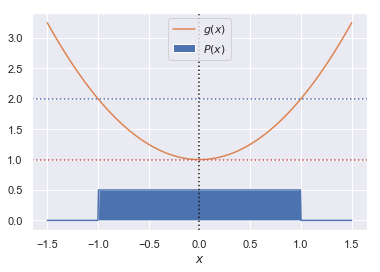

In [32]:
def jensen(a=1, b=1, c=1):
    x = np.linspace(-1.5 * c, 1.5 * c, 500)
    g = a * x ** 2 + b
    P = (np.abs(x) < c) * 0.5 / c
    plt.fill_between(x, P, label='$P(x)$')
    plt.plot(x, P)
    plt.plot(x, g, label='$g(x)$')
    plt.legend(loc='upper center', frameon=True)
    plt.axvline(0, c='k', ls=':')
    plt.axhline(b, c='r', ls=':')
    plt.axhline(a * c ** 2 + b, c='b', ls=':')
    plt.xlabel('$x$')
    
jensen()

**EXERCISE:** Match the following values to the dotted lines in the graph above of the function $g(x)$ and probability density $P(x)$:
 1. $\langle x\rangle = \int dx\, x P(x)$
 2. $\langle g(x)\rangle = \int dx\, g(x)\,P(x)$
 3. $g(\langle x\rangle) = g\left( \int dx\, x P(x)\right)$
 
Is $g(x)$ convex? Is Jensen's inequality satisfied?

Answer:
 1. Vertical (black) line.
 2. Upper horizontal (blue) line.
 3. Lower horizontal (red) line.
 
Jensen's inequality is satisfied, as required since $g(x)$ is convex.

### Useful Distributions

There are many named statistical distributions with useful properties and/or interesting history.  For example, in the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) module we find a large number of 1D continuous random variable distributions:

In [33]:
len(scipy.stats.rv_continuous.__subclasses__())

93

and a smaller number of 1D discrete distributions:

In [34]:
len(scipy.stats.rv_discrete.__subclasses__())

13

and multidimensional continuous distributions:

In [35]:
len(scipy.stats._multivariate.multi_rv_generic.__subclasses__())

9

In [36]:
scipy.stats.norm?

You will likely never need most of this distributions, but it is useful to know about them. Most have special applications that they were created for, but can also be useful as building blocks of an empirical distribution when you just want something that looks like the data.

It is useful to group the large number of 1D continuous distributions according to their general shape. We will use the function below for a quick visual tour of some PDFs in each group:

In [15]:
def pdf_demo(xlo, xhi, **kwargs):
    # kwargs organizes as follows:
    # name = "arglist;arglist;..." , ...
    # - arglist = args,args,...
    # Ex kwargs: scrystalball='beta=1,m=3,loc=6;beta=10,m=3,loc=6', norm='scale=1'
    x = np.linspace(xlo, xhi, 200)
    cmap = sns.color_palette().as_hex()
    for i, name in enumerate(kwargs):
        for j, arglist in enumerate(kwargs[name].split(';')):
            # Separate string of arguments into dictionary
            args = eval('dict(' + arglist + ')')
            y = eval('scipy.stats.' + name)(**args).pdf(x)
            plt.plot(x, y, c=cmap[i], ls=('-','--',':')[j], label=name)
    plt.xlim(x[0], x[-1])
    plt.legend(fontsize='large')

First, the centered symmetric peaked distributions, including the ubiquitous Gaussian (here called "norm") and Lorentzian (here called "cauchy").  Each of these can be re-centered using the `loc` (location) parameter and broadened using `scale`:

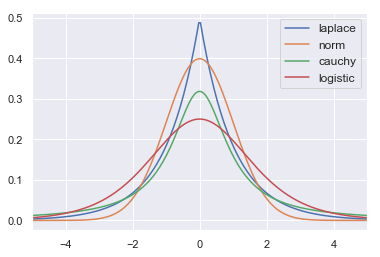

In [16]:
pdf_demo(-5, +5, laplace='scale=1', norm='scale=1', cauchy='scale=1', logistic='scale=1')

There are also some more specialized asymmetric "bump" distributions that are particularly useful for modeling histograms of reconstructed particle masses (even more specialized is the Cruijff function used [here](https://arxiv.org/abs/1005.4087)):

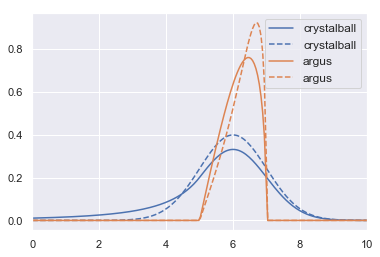

In [17]:
pdf_demo(0, 10, crystalball='beta=1,m=3,loc=6;beta=10,m=3,loc=6', argus='chi=0.5,loc=5,scale=2;chi=1.5,loc=5,scale=2')

Next, the "one-sided" distributions that are only defined for $x \ge 0$. Most of these smoothly transition from peaking at the origin to peaking at $x > 0$ as some parameter is varied. These are useful building blocks for quantities that must be positive, e.g., errors or densities.

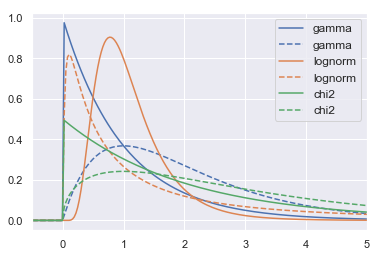

In [18]:
pdf_demo(-0.5, 5, gamma='a=1;a=2', lognorm='s=0.5;s=1.5', chi2='df=2;df=3')

Another useful group are the "bounded" distributions, especially the versatile two-parameter [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution):

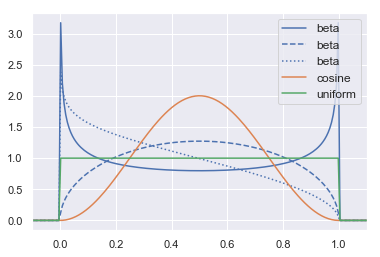

In [19]:
pdf_demo(-0.1, 1.1, beta='a=.7,b=.7;a=1.5,b=1.5;a=.9,b=1.5', cosine='loc=0.5,scale=0.159',
         uniform='scale=1')

All of the 1D continuous distributions share the same API (via a [common base class](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html)), and allow you to perform useful operations including:
 - Evaluate the PDF, log(PDF), CDF or log(CDF).
 - Generate random values from the distribution.
 - Calculate expectation values of moment functions or even arbitrary functions.

The API also allows you to estimate the values of distribution parameters that best describe some data, but we will soon see better approaches to this "regression" problem.

In [16]:
def rv_continuous_demo(xlo, xhi, dist, seed=123, n=500):
    x = np.linspace(xlo, xhi, 200)
    P = dist.pdf(x)
    plt.plot(x, P, ls='-', label='PDF $P(x)$')

    g = lambda x: (0.7 - 0.3 * (x - xlo) / (xhi - xlo)) * np.percentile(P, 95)
    plt.plot(x, g(x), ':', label='$g(x)$')
    print('<g> =', dist.expect(g))
    
    gen = np.random.RandomState(seed=seed)
    data = dist.rvs(size=n, random_state=gen)
    plt.hist(data, range=(xlo, xhi), bins=20, histtype='stepfilled',
             alpha=0.25, density=True, label='Random')
    
    plt.ylim(0, None)
    plt.grid(axis='y')
    plt.legend(loc='upper left', fontsize='large')
    rhs = plt.twinx()
    rhs.set_ylabel('CDF')
    rhs.set_ylim(0., 1.05)
    rhs.grid(False)
    rhs.plot(x, dist.cdf(x), 'k--')
    plt.xlim(xlo, xhi)

<g> = 0.21420671411482317


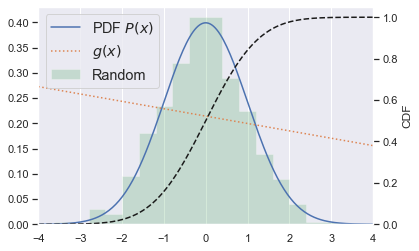

In [17]:
rv_continuous_demo(-4, +4, scipy.stats.norm())

<g> = 0.8840573776021254


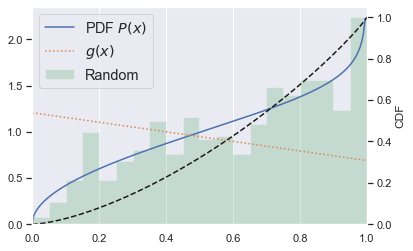

In [18]:
rv_continuous_demo(0, 1, scipy.stats.beta(a=1.5,b=0.9))

The [chi2 distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) ($\chi^2$) is especially useful for confidence interval calculations. Here are two handy utilities that you will likely need at some point (using the CDF and [inverse-CDF](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.ppf.html#scipy.stats.rv_continuous.ppf) functions):

In [23]:
def nsigmas_to_CL(nsigmas=1., D=1):
    return scipy.stats.chi2.cdf(x=nsigmas ** 2, df=D)
def CL_to_nsigmas(CL=0.95, D=1):
    return np.sqrt(scipy.stats.chi2.ppf(q=CL, df=D))

For example, a "1-sigma" error bar contains ~68% of a Gaussian distribution in 1D, but a 2D "1-sigma" contour only contains ~39%:

In [24]:
nsigmas_to_CL(nsigmas=1, D=[1, 2])

array([0.68268949, 0.39346934])

To find the number of sigmas required to enclose a specific integrated probability (aka "confidence level (CL)") in D dimensions:

In [25]:
CL_to_nsigmas(CL=0.95, D=[1, 2])

array([1.95996398, 2.44774683])

Scale $\sigma_i$ and $\sigma_j$ both by `nsigmas` to adjust the ellipses we drew above to enclose a desired CL (or, equivalently, scale the covariance matrix by `nsigmas**2`).

Finally, there are some essential discrete random variable distributions, where the PDF is replaced with a **probability mass function (PMF)**:

In [26]:
def pmf_demo(klo, khi, **kwargs):
    k = np.arange(klo, khi + 1)
    cmap = sns.color_palette().as_hex()
    histopts = {'bins': khi-klo+1, 'range': (klo-0.5,khi+0.5), 'histtype': 'step', 'lw': 2}
    for i, name in enumerate(kwargs):
        for j, arglist in enumerate(kwargs[name].split(';')):
            args = eval('dict(' + arglist + ')')
            y = eval('scipy.stats.' + name)(**args).pmf(k)
            plt.hist(k, weights=y, color=cmap[i], ls=('-','--',':')[j], label=name, **histopts)
    plt.legend(fontsize='large')

The one-sided [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), which describes the statistics of (uncorrelated) counting measurement (which are ubiquitous in astronomy and particle physics):

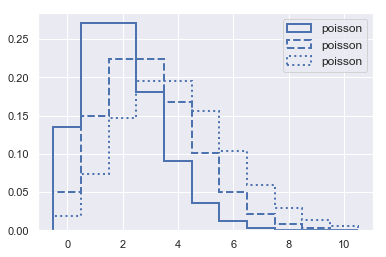

In [27]:
pmf_demo(0, 10, poisson='mu=2;mu=3;mu=4')

The bounded [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), which is related to the beta distribution above, and describes the statistics of ratios of counting measurements (efficiency, purity, completeness, ...):

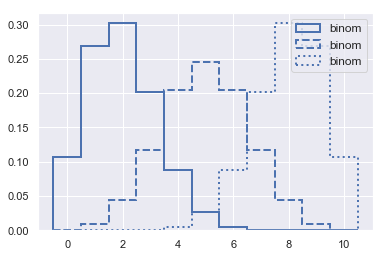

In [28]:
pmf_demo(0, 10, binom='n=10,p=0.2;n=10,p=0.5;n=10,p=0.8')

**EXERCISE:** Fill in the function below to generate `nsample` samples of size `size` from an arbitrary 1D continuous distribution, and then display an `sns.distplot` of the mean values of each generated sample:
```
def central_limit_demo(dist, nsample, size, seed=123):
    gen = np.random.RandomState(seed=seed)
    ...
```
Test your function using:
```
central_limit_demo(scipy.stats.uniform(scale=1), nsample=100, size=100)
central_limit_demo(scipy.stats.lognorm(s=0.5), nsample=100, size=100)
```

In [29]:
def central_limit_demo(dist, nsample, size, seed=123):
    gen = np.random.RandomState(seed=seed)
    means = []
    for i in range(nsample):
        data = dist.rvs(size=size, random_state=gen)
        means.append(np.mean(data))
    sns.distplot(means)

/Users/david/anaconda3/envs/MLS/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


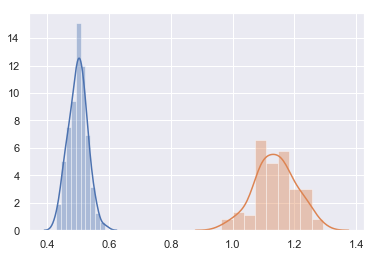

In [30]:
central_limit_demo(scipy.stats.uniform(scale=1), nsample=100, size=100)
central_limit_demo(scipy.stats.lognorm(s=0.5), nsample=100, size=100)

This exercise provides a numerical demonstration of the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), which asserts that the mean (or sum) of samples drawn from any distribution tends to have a Gaussian distribution.

Here is a nicer [interactive demonstration](http://students.brown.edu/seeing-theory/probability-distributions/index.html#section3) you can experiment with.

For a more powerful statistical toolbox than [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html), try the python [statsmodels](http://www.statsmodels.org/) package. Going beyond python, the [R language](https://www.r-project.org/about.html) is designed specifically for "statistical computing" (and [integrated in jupyter](https://irkernel.github.io/)), and [RooFit](https://root.cern.ch/roofit-20-minutes) is a "a toolkit for modeling the expected distribution of events in a physics analysis" integrated into the [ROOT framework](https://root.cern.ch/).

We will be soon be talking more about the general problem of "fitting" the parameters of a distribution to match some data.